In [1]:
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt
sym.init_printing(use_latex="mathjax")
from scipy.optimize import root

In [2]:
v=0.25
lbg=0.1
k=0.0003
kbg=0.4
I0=300.0
mumax=1.2
romax=0.2
m=15.0
qmax=0.04
qmin=0.004
h=120.0
d=10.0


N=1000
zmax = 30
z = np.linspace(0,zmax,N)   

A1_guess = 100.0                 #100
Rb1_guess = 2.2                  #5 * ( qmin * A1_guess )
Rd1_guess = 30.0                 #89.33333333333

A1,Rb1,Rd1 = sym.symbols('A1 Rb1 Rd1')


In [13]:
def q(Rb, A):
    return Rb/A
    
def p(I,q, mumax=mumax, qmin=qmin, h=h):
    return mumax * (1 - qmin/q) * (I/(h + I))

def ro(q, Rd, romax = romax, qmax = qmax, qmin=qmin, m=m):
    return romax * (qmax-q)/(qmax-qmin) * ( Rd/(m + Rd) )

In [7]:
def plankton_equations(y):
    A1 = y[0]
    A2 = y[1]
    Rb1 = y[2]
    Rb2 = y[3]
    Rd1 = y[4]
    Rd2 = y[5]
    I = y[6]
    q = Rb1/A1
    
    derivatives = np.array((-A2,
                     (v*A2 + lbg*A1 - p(I,q)*A1)/d,
                     -Rb2,
                     (v*Rb2 + lbg*Rb1 - ro(q,Rd1)*A1)/d,
                     -Rd2,
                     (ro(q,Rd1)*A1 - lbg*Rb1)/d,
                     -(k*A1 + kbg)*I))
    return derivatives

initial_conditions = np.array([A1_guess,
                              v*A1_guess/d,
                              Rb1_guess,
                              v*Rb1_guess/d,
                              Rd1_guess,
                              0,
                              I0])

In [8]:
def one_step_rk4(f, xvinit, Tmax, N):
    xv = xvinit                            # set first ROW to the initial conditions
    h = Tmax / N                           # step size
    k1 = f(xv)
    k2 = f(xv + h/2.0*k1)
    k3 = f(xv + h/2.0*k2)
    k4 = f(xv + h*k3)
    next_step = xv[0] + h/6.0 *( k1 + 2*k2 + 2*k3 + k4)
    return next_step

In [9]:
def rk4(f, xvinit, Tmax, N):               # N=number of steps
    T = np.linspace(0, Tmax, N+1)
    xv = np.zeros( (len(T), len(xvinit)) ) # matrix with # cols=# initial conditions
    xv[0] = xvinit                         # set first ROW = initial conditions
    h = Tmax / N                           # step size
    for i in range(N):
        k1 = f(xv[i])
        k2 = f(xv[i] + h/2.0*k1)
        k3 = f(xv[i] + h/2.0*k2)
        k4 = f(xv[i] + h*k3)
        xv[i+1] = xv[i] + h/6.0 *( k1 + 2*k2 + 2*k3 + k4)
    return T, xv

In [10]:
# To see how first 2 steps behave
first_step = one_step_rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)
second_step = one_step_rk4(lambda x: plankton_equations(x), first_step, zmax, N)

In [11]:
z, derivs = rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)

In [14]:
results = pd.DataFrame(derivs)
results.columns = ['A1','A2','Rb1','Rb2','Rd1','Rd2','I']
results = results.set_index(z)
results.index.name = 'z'
results['R'] = results.loc[:,['Rb1','Rd1']].sum(axis=1)
results['q'] = q(np.array(results.Rb1),np.array(results.A1))
results['ro'] = ro(np.array(results.q), np.array(results.Rd1))
results['p'] = p(np.array(results.I),np.array(results.q))

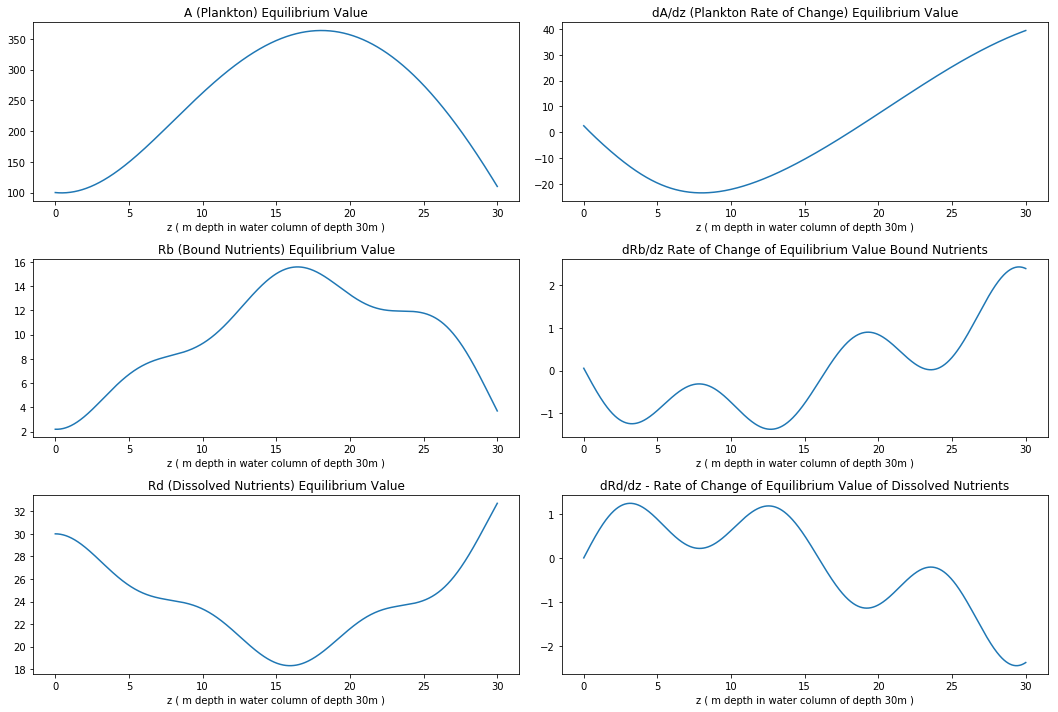

In [15]:
fig, axs = plt.subplots(3,2, figsize=(15,10))

axs[0,0].plot(results.A1)
axs[0,0].set_title('A (Plankton) Equilibrium Value')
axs[0,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[0,1].plot(results.A2)
axs[0,1].set_title('dA/dz (Plankton Rate of Change) Equilibrium Value')
axs[0,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[1,0].plot(results.Rb1)
axs[1,0].set_title('Rb (Bound Nutrients) Equilibrium Value')
axs[1,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[1,1].plot(results.Rb2)
axs[1,1].set_title('dRb/dz Rate of Change of Equilibrium Value Bound Nutrients')
axs[1,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[2,0].plot(results.Rd1)
axs[2,0].set_title('Rd (Dissolved Nutrients) Equilibrium Value')
axs[2,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[2,1].plot(results.Rd2)
axs[2,1].set_title('dRd/dz - Rate of Change of Equilibrium Value of Dissolved Nutrients')
axs[2,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

plt.tight_layout()

Text(0.5, 0, 'z ( m depth in water column of depth 30m )')

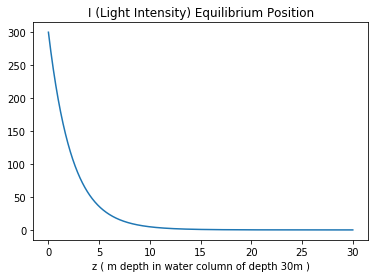

In [13]:
plt.plot(results.I)
plt.title('I (Light Intensity) Equilibrium Position')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

### Plots of Functions ro, p and q

Text(0.5, 1.0, 'ro')

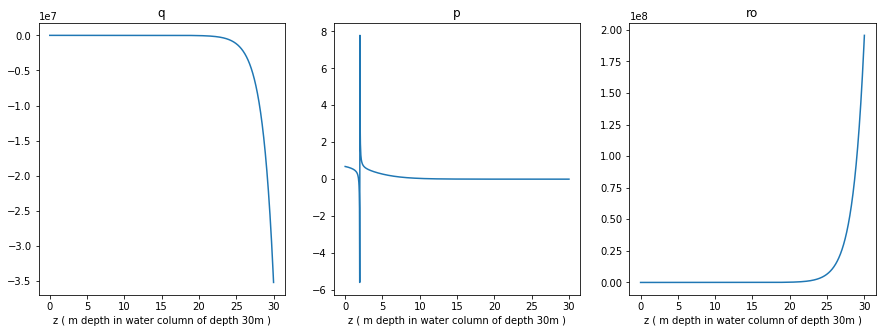

In [61]:
fig,axs = plt.subplots(1,3, figsize=(15,5) )

axs[0].plot(results.q)
axs[1].plot(results.p)
axs[2].plot(results.ro)
axs[0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))
axs[1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))
axs[2].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))
axs[0].set_title('q')
axs[1].set_title('p')
axs[2].set_title('ro')

## For Shooting Method:

In [62]:
def end_values(values_at_zmax_integrated):
    """Creates Robin boundary conditions using values at zmax of integrated function and adds known BCs."""
    
    Rb1_end = values_at_zmax_integrated[1]
    Rd2_end = values_at_zmax_integrated[3]
    values_at_zmax = np.array([0,       # A2
                          Rb1_end,  # Rb1 Robin Boundary Condition
                          0,            # Rb2
                          v*Rb1_end/d]) # Rd2 Robin Boundary Condition
    return values_at_zmax

def residuals(initial_conditions):
    """Takes initial guess array of length 7 and returns residuals array \ncontaining residuals for A2,Rb1,Rb2,Rd2 and padded with 3 zeroes."""
    
    z, derivs = rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)
    
    residuals = np.zeros(7)
    values_at_zmax_integrated = derivs[N,[2,3,4,6]]       # actual values of A2,Rb1,Rb2,Rd2 obtained through integration
    BCs_at_zmax = end_values(values_at_zmax_integrated)   # expected relationship between values with Robin BCs
    residuals[[2,3,4,6]] = BCs_at_zmax - values_at_zmax_integrated
    
    return residuals

[Notes on method to use ](https://stackoverflow.com/questions/30636988/python-scipy-fsolve-mismatch-between-the-input-and-output-shape-of-the-func-a)

In [63]:
root(residuals, initial_conditions, method='lm')

   cov_x: array([[ 1.16290719e-10, -4.20840032e-10, -2.66157689e-13,
        -1.24559167e-11, -1.66577227e-09,  5.18216680e-10,
         8.91493465e-07],
       [-4.53745929e-10, -6.43716105e-09,  5.87214975e-13,
         3.51696242e-11,  1.19576621e-08,  2.65879792e-09,
        -9.91024736e-06],
       [-2.71330873e-13,  5.30623402e-13,  1.21363715e-15,
         1.57970086e-14,  2.95491737e-12, -1.00414527e-12,
        -1.25175748e-09],
       [-1.34131968e-11,  3.51093328e-11,  1.74338607e-14,
         4.58645989e-13,  3.26767347e-10, -2.40899104e-10,
         1.89852217e-08],
       [-1.51484467e-09,  1.09401252e-08,  2.53538356e-12,
         2.96889191e-10,  1.04587131e-08,  2.59124285e-08,
        -1.66396687e-05],
       [-1.03636370e-10,  5.05583395e-09,  4.42159325e-13,
        -1.70026481e-10,  3.41474139e-08, -2.68131814e-07,
        -4.35413163e-05],
       [ 8.36937429e-07, -9.46055751e-06, -1.08723560e-09,
         3.21673088e-08, -1.70152192e-05, -3.90172573e-05,
        